In [1]:
#group by 
#nonce
#block_time (%Y-%m-%d %H:%M)

In [2]:
import pandas as pd
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import pickle
import subprocess
import sys
from networkx.algorithms.community import asyn_lpa_communities as lpa

pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 10000)


def Time2Str(tsm):
    t1 = datetime.datetime.fromisoformat(tsm)
    t0 = t1-datetime.timedelta(days=0, hours=1)
    t2 = t1+datetime.timedelta(days=0, hours=1)
    str1 = t0.strftime("%Y%m%d")+'(' +str(t0.hour).rjust(2,'0')+'#'+str(t1.hour).rjust(2,'0')+')'
    str2 = t1.strftime("%Y%m%d")+'(' +str(t1.hour).rjust(2,'0')+'#'+str(t2.hour).rjust(2,'0')+')'
    return str1+';'+str2


def parse_date_convert_min(date,format='%Y-%m-%d %H:%M'):
    parse_date=parse(date)
    return parse_date.strftime(format)

def parse_date_convert_year(date,format='%Y'):
    parse_date=parse(date)
    return parse_date.strftime(format)

def parse_date_convert_day(date,format='%Y-%m-%d'):
    parse_date=parse(date)
    return parse_date.strftime(format)

def parse_date_convert_month(date,format='%Y-%m'):
    if pd.isna(date):
        return ''
    else:
        parse_date=parse(date)
        return parse_date.strftime(format)

def parse_date_convert_timestamp(date):
    parse_date=parse(date)
    return str(int(parse_date.timestamp()))

def parse_date_convert_hour(date,format='%Y-%m-%d %H'):
    parse_date=parse(date)
    return parse_date.strftime(format)


def log_graph_info(G):
    maxG_triangle=nx.triangles(G)
    print('共构建{:,}个节点、{:,}条边、总度数为{:,}、平均度为{:.2f}、三角计数为{:,}'.format(G.number_of_nodes(),
                                         G.number_of_edges(),
                                                  np.sum([d for _, d in G.degree()]),
                                                              np.mean([d for _, d in G.degree()]),sum(maxG_triangle.values())
                                        ))
def plt_graph(G,nodes):
    plt.figure(figsize=(40,20),dpi=90)
    color_map = []
    for node in G:
        if node in nodes:
            color_map.append('blue')
        else: 
            color_map.append('green') 
    pos=nx.spring_layout(G)
    nx.draw(G,pos,node_color=color_map)
    nx.draw_networkx_nodes(G, pos,node_color=color_map)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    
def init_graph(df_graph,attr_col,attr=True,is_directed=True):
    df_graph=df_graph.reset_index(drop=True)
    max_G = nx.Graph()
    if is_directed:
        max_G = nx.DiGraph()
#     attr_col='tokenId'
    for i in range(len(df_graph)):
        code1 = df_graph.loc[i, 'from']
        code2 = df_graph.loc[i, 'to']
        if attr:
            attr_val = df_graph.loc[i, attr_col]
            max_G.add_edge(str(code1), str(code2), weight=attr_val)
        else:
            max_G.add_edge(str(code1), str(code2))
    return max_G

def convert_sel_buy(to,node):
    if to==node:
        return 'to'
    else:
        return 'from'

In [3]:
#load transaction data
df1=pd.read_csv('dune1.csv') #ETH , gnosis , BSC , OPT, ARBI Safe history transactions
df2=pd.read_csv('dune2.csv')
df3=pd.read_csv('dune3.csv')
df4=pd.read_csv('dune4.csv')
df5=pd.read_csv('dune5.csv')
df6=pd.read_csv('dune6.csv')
df_ords=pd.concat([df1,df2,df3,df4,df5,df6])
user_df=pd.read_csv('safe_user_allocations_reworked.csv')
user_df.rename(columns={'safe_address':'addr'},inplace=True)

df_ords['block_time_month']=df_ords['block_time'].apply(parse_date_convert_month)
df_ords['block_time_day']=df_ords['block_time'].apply(parse_date_convert_day)
df_ords['block_time_min']=df_ords['block_time'].apply(parse_date_convert_min)
df_ords['block_time_hour']=df_ords['block_time'].apply(parse_date_convert_hour)

df_ords['value_conv']=df_ords.value.astype('float64')
df_ords['token_vol']=df_ords['value_conv']/1000000000000000000

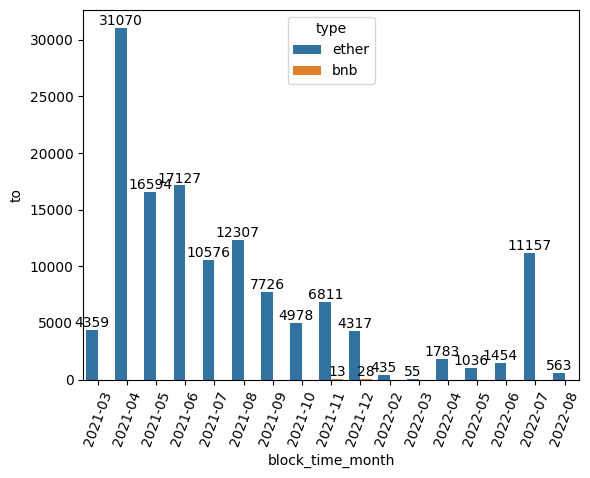

In [23]:
#same pattern month 2022-07


df_same_stat=df_ords.groupby(['block_time_min','nonce','type']).agg({'to':'count'}).reset_index()

df_same_stat['block_time_day']=df_same_stat.block_time_min.map(lambda x:x[0:10])

df_same_stat_day=df_same_stat[df_same_stat['to']>10][['block_time_min','nonce','type']]

df_safe_detail=pd.merge(df_same_stat_day,df_ords,how='inner',on=['nonce','type','block_time_min'])

df_same_pattern_monthly=df_safe_detail.groupby(['block_time_month','type']).agg({'to':'count'}).reset_index()

ax = sns.barplot(x="block_time_month", y="to", hue='type',data=df_same_pattern_monthly)
plt.xticks(rotation=70)

for i in ax.containers:
    ax.bar_label(i,)


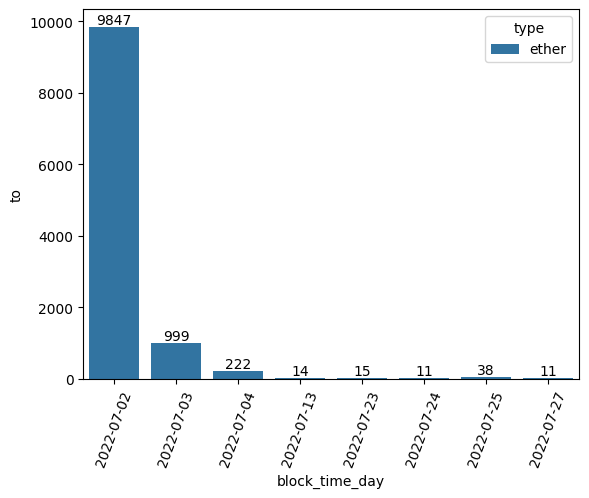

In [50]:
#same pattern day 2022-07-02

df_same_pattern_day=df_safe_detail[
                                    (df_safe_detail['block_time_month']=='2022-07')
                                   ].groupby(['block_time_day','type']).agg({'to':'count'}).reset_index()

ax = sns.barplot(x="block_time_day", y="to", hue='type',data=df_same_pattern_day)
plt.xticks(rotation=70)

for i in ax.containers:
    ax.bar_label(i,)

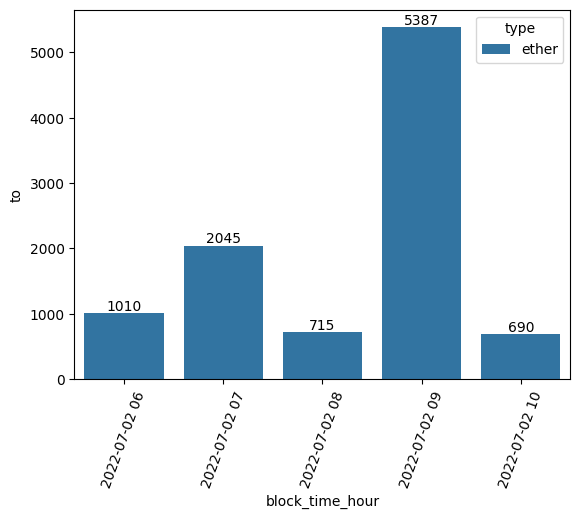

In [52]:
#same pattern month 2022-07-02 06:00 ~ 10:00

df_same_pattern_hour=df_safe_detail[(df_safe_detail['block_time_day']=='2022-07-02')
                                   ].groupby(['block_time_hour','type']).agg({'to':'count'}).reset_index()

ax = sns.barplot(x="block_time_hour", y="to", hue='type',data=df_same_pattern_hour)
plt.xticks(rotation=70)

for i in ax.containers:
    ax.bar_label(i,)

In [75]:
# get all transactions details between 2022-07-02 06:00 and 2022-07-02 06:00 10:00 on all chains.

df_blk_lst=df_safe_detail[((df_safe_detail['block_time_hour']>='2022-07-02 06') &
                                    (df_safe_detail['block_time_hour']<='2022-07-02 10'))]['addr']
addr_set=df_blk_lst.unique()

df_blk_lst=pd.DataFrame(addr_set,columns=['addr'])
df_blk_ords=pd.merge(df_ords,df_blk_lst,how='inner',on='addr')

df_blk_ords_graph=df_blk_ords.groupby(['addr','type']).agg({'token_vol':['sum','count'],'from':[lambda x: x.nunique()]}).reset_index()
df_blk_ords_graph.columns = df_blk_ords_graph.columns.map('_'.join).str.strip('_')


df_blk_ords_block_time=df_blk_ords.sort_values(['addr','block_time'],ascending=True).groupby(['addr']).agg({'block_time':list}).reset_index()
df_all=pd.merge(df_blk_ords_graph,df_blk_ords_block_time,on=['addr'],how='inner')


In [76]:
#
df=df_blk_ords_graph.groupby(['type','token_vol_count','token_vol_sum','from_<lambda>']).agg({'addr':'count'}).reset_index().sort_values(by=['addr'],ascending=False)



In [77]:
df=df[df['addr']>10]
df.rename(columns={"token_vol_sum": "total_volumn", "token_vol_count": "ETH","from_<lambda>":"from"})

,type,ETH,total_volumn,from,addr
2,ether,11,0.000001,1,326
12,ether,24,0.000002,2,210
9,ether,22,0.000003,2,66
10,ether,23,0.000003,2,32
8,ether,21,0.000003,2,16


In [78]:
df_graph_visual=df_blk_ords.groupby(['from','to','type']).agg({'token_vol':'count'}).reset_index()

In [126]:
#suspicious condition 
# batch 1:
# 11 transactions on evm with 1 'from' address.
eth_transactions=11
from_attrs=1

blk_addrs=set(df_blk_ords_graph[(df_blk_ords_graph['token_vol_count']==eth_transactions) & 
                                (df_blk_ords_graph['from_<lambda>']==from_attrs)]['addr'])
df_blk_addrs_1=pd.DataFrame(blk_addrs,columns=['to'])
df_blk_graph_1=pd.merge(df_graph_visual,df_blk_addrs_1,how='inner',on='to')

#suspicious behavior group1

group1=df_all[(df_all['token_vol_count']==eth_transactions) & 
                                (df_all['from_<lambda>']==from_attrs)].sort_values(by='block_time')

group1=group1.rename(columns={"token_vol_sum": "total_volumn", "token_vol_count": "ETH","from_<lambda>":"froms"})
group1['BSC']=0
group1['Gnosis']=0
group1['Optimism']=0
group1['Arbitrum']=0
group1.to_csv('sybil_attack_report_batch_1#307.csv')
group1.head(3)

,addr,type,total_volumn,ETH,froms,block_time,BSC,Gnosis,Optimism,Arbitrum
395,0x9b921878ad39abe699eb09763712a4e1a34999a4,ether,0.000001,11,1,"[2022-07-02T06:17:40Z, 2022-07-02T06:58:32Z, 2...",0,0,0,0
432,0xa91a7d850bf0a254f37450cf8b6697a387a50672,ether,0.000001,11,1,"[2022-07-02T06:17:40Z, 2022-07-02T06:58:32Z, 2...",0,0,0,0
54,0x1562b16721899dd014caa35728236eb6f14d6c85,ether,0.000001,11,1,"[2022-07-02T06:17:40Z, 2022-07-02T06:58:32Z, 2...",0,0,0,0


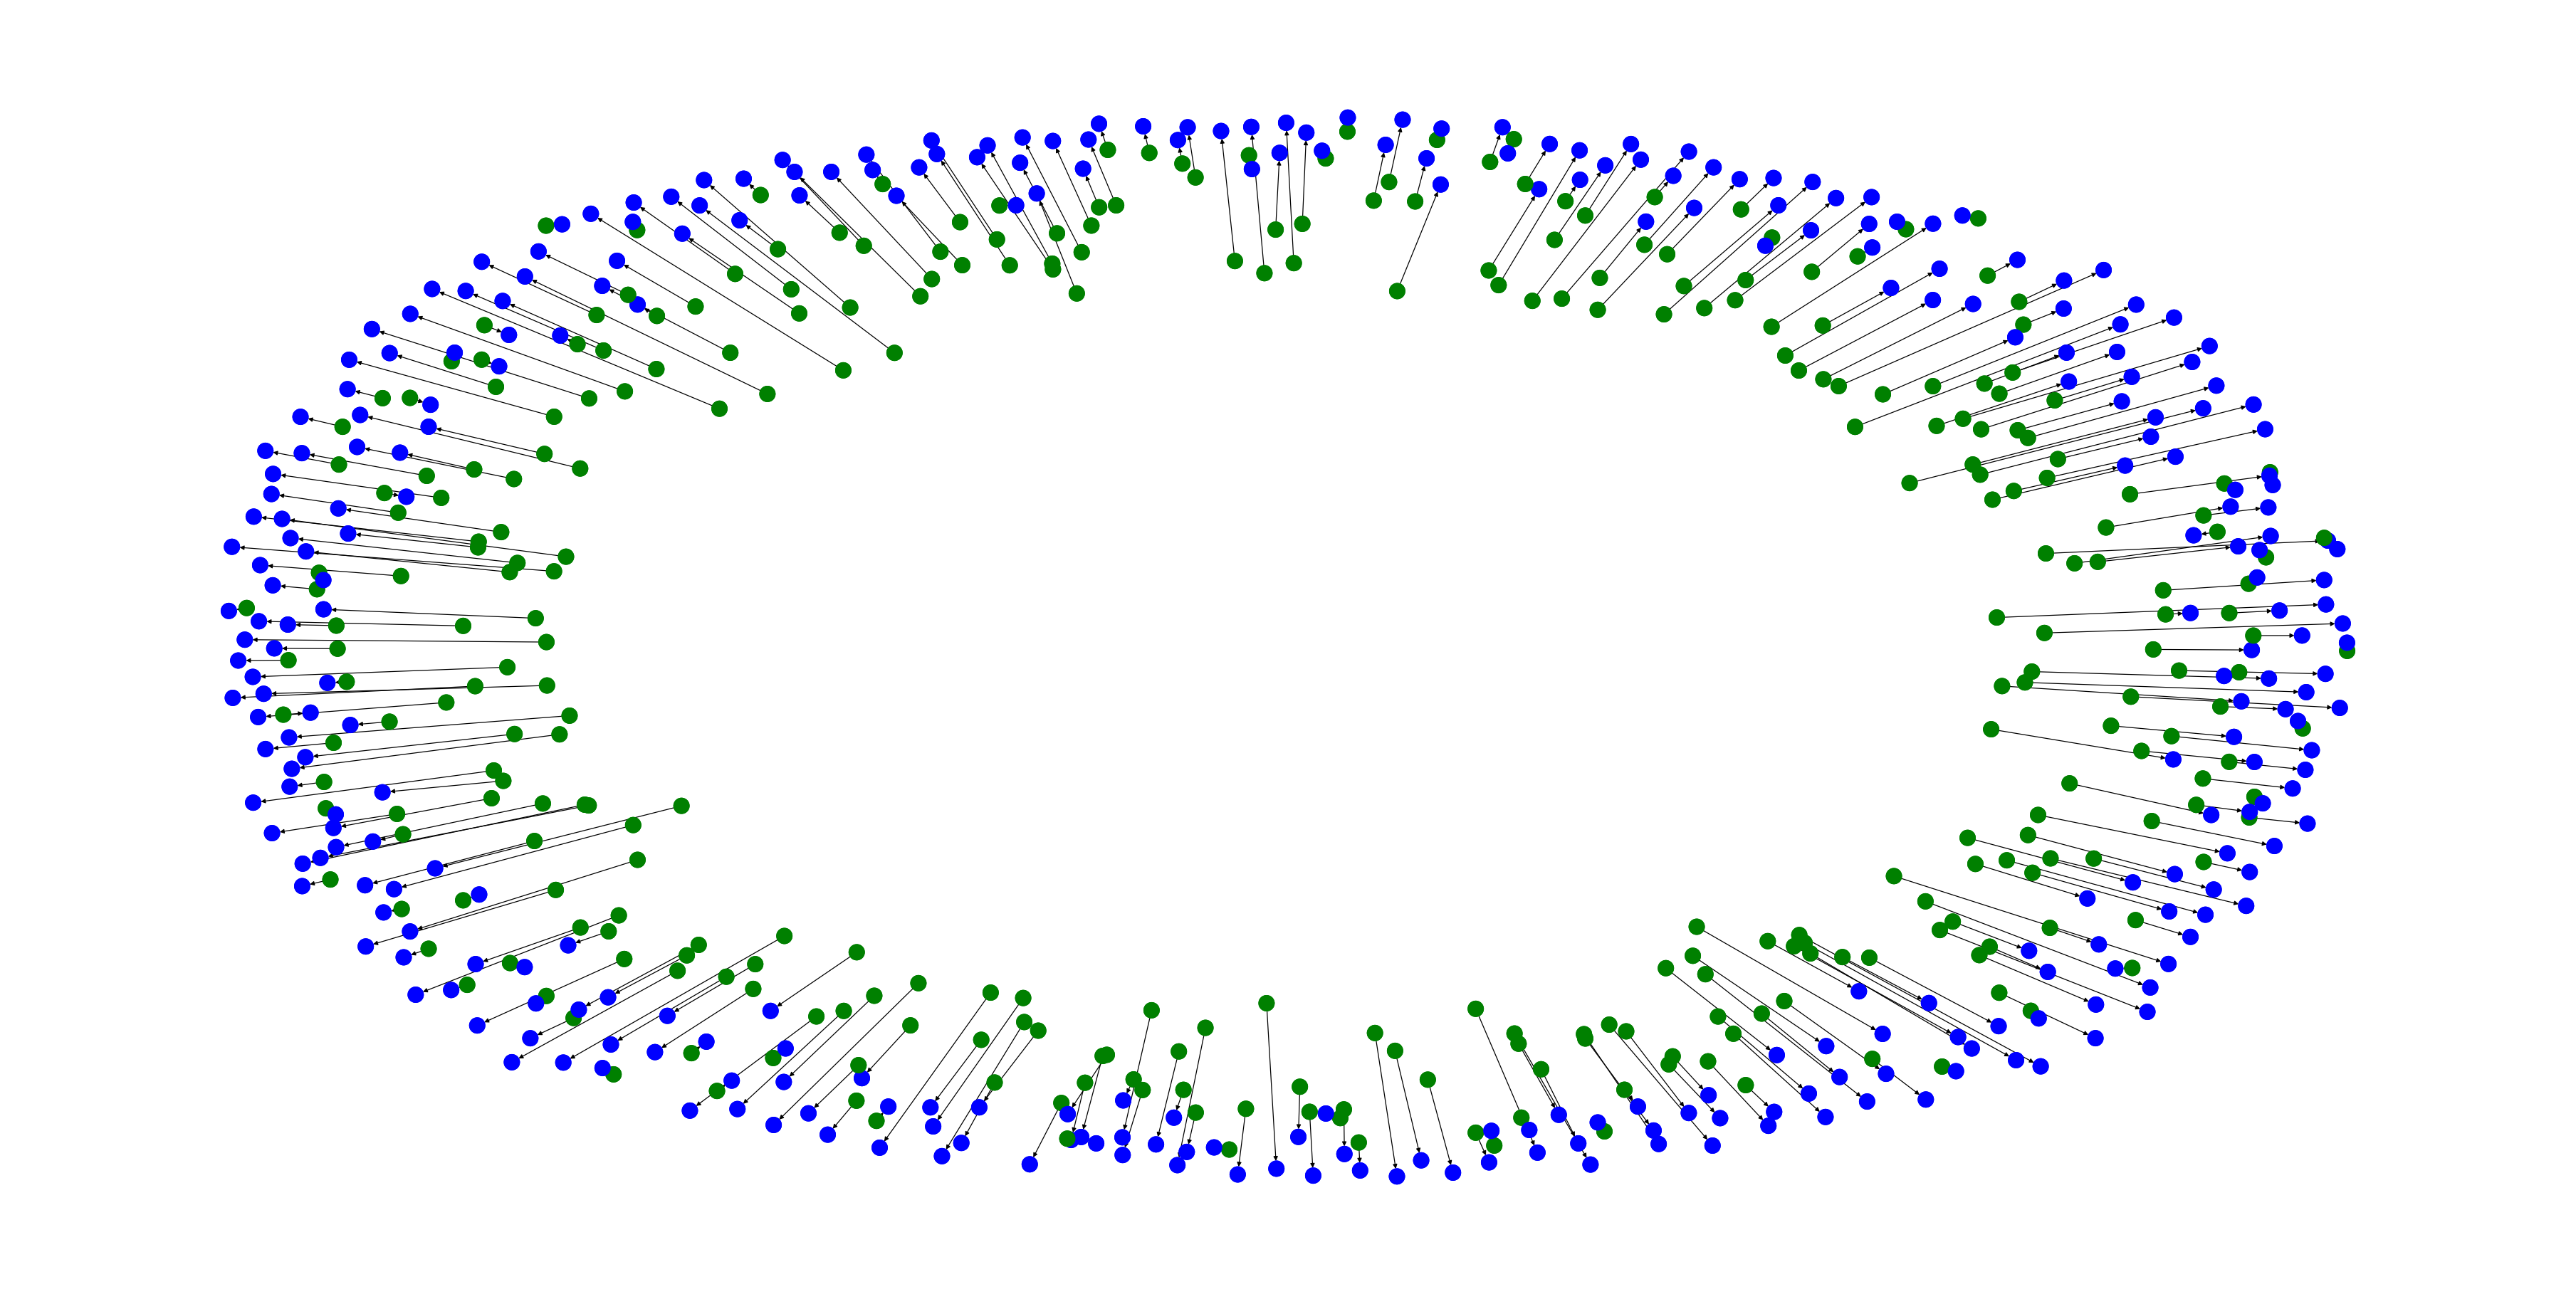

In [107]:
#plot group 1 transaction graph
G=init_graph(df_blk_graph_1,'token_vol',False,True)
plt_graph(G,df_blk_graph_1['to'].values)

In [128]:
# suspicious condition 
# batch 2:
# 24 transactions on evm with 2 'from' address.
eth_transactions=24
from_attrs=2

blk_addrs=set(df_blk_ords_graph[(df_blk_ords_graph['token_vol_count']==eth_transactions) & 
                                (df_blk_ords_graph['from_<lambda>']==from_attrs)]['addr'])
df_blk_addrs_2=pd.DataFrame(blk_addrs,columns=['to'])
df_blk_graph_2=pd.merge(df_graph_visual,df_blk_addrs_2,how='inner',on='to')

#suspicious behavior group2

batch2=df_all[(df_all['token_vol_count']==eth_transactions) & 
                                (df_all['from_<lambda>']==from_attrs)].sort_values(by='block_time')

batch2=batch2.rename(columns={"token_vol_sum": "total_volumn", "token_vol_count": "ETH","from_<lambda>":"froms"})
batch2['BSC']=0
batch2['Gnosis']=0
batch2['Optimism']=0
batch2['Arbitrum']=0
batch2.to_csv('sybil_attack_report_batch_2#307.csv')

batch2.head(3)

,addr,type,total_volumn,ETH,froms,block_time,BSC,Gnosis,Optimism,Arbitrum
70,0x1d7e358690dfa1f967b9da999e1f64eb8620b1db,ether,0.000012,24,2,"[2022-06-21T07:08:20Z, 2022-06-21T07:08:38Z, 2...",0,0,0,0
305,0x7c5d2e25eecc66d9972eb1ad78cba235b30f9a29,ether,0.000002,24,2,"[2022-07-02T06:17:40Z, 2022-07-02T06:17:40Z, 2...",0,0,0,0
315,0x7ea9bcb48f9758039ad70adc951e6f7f29a521f4,ether,0.000002,24,2,"[2022-07-02T06:17:40Z, 2022-07-02T06:17:40Z, 2...",0,0,0,0


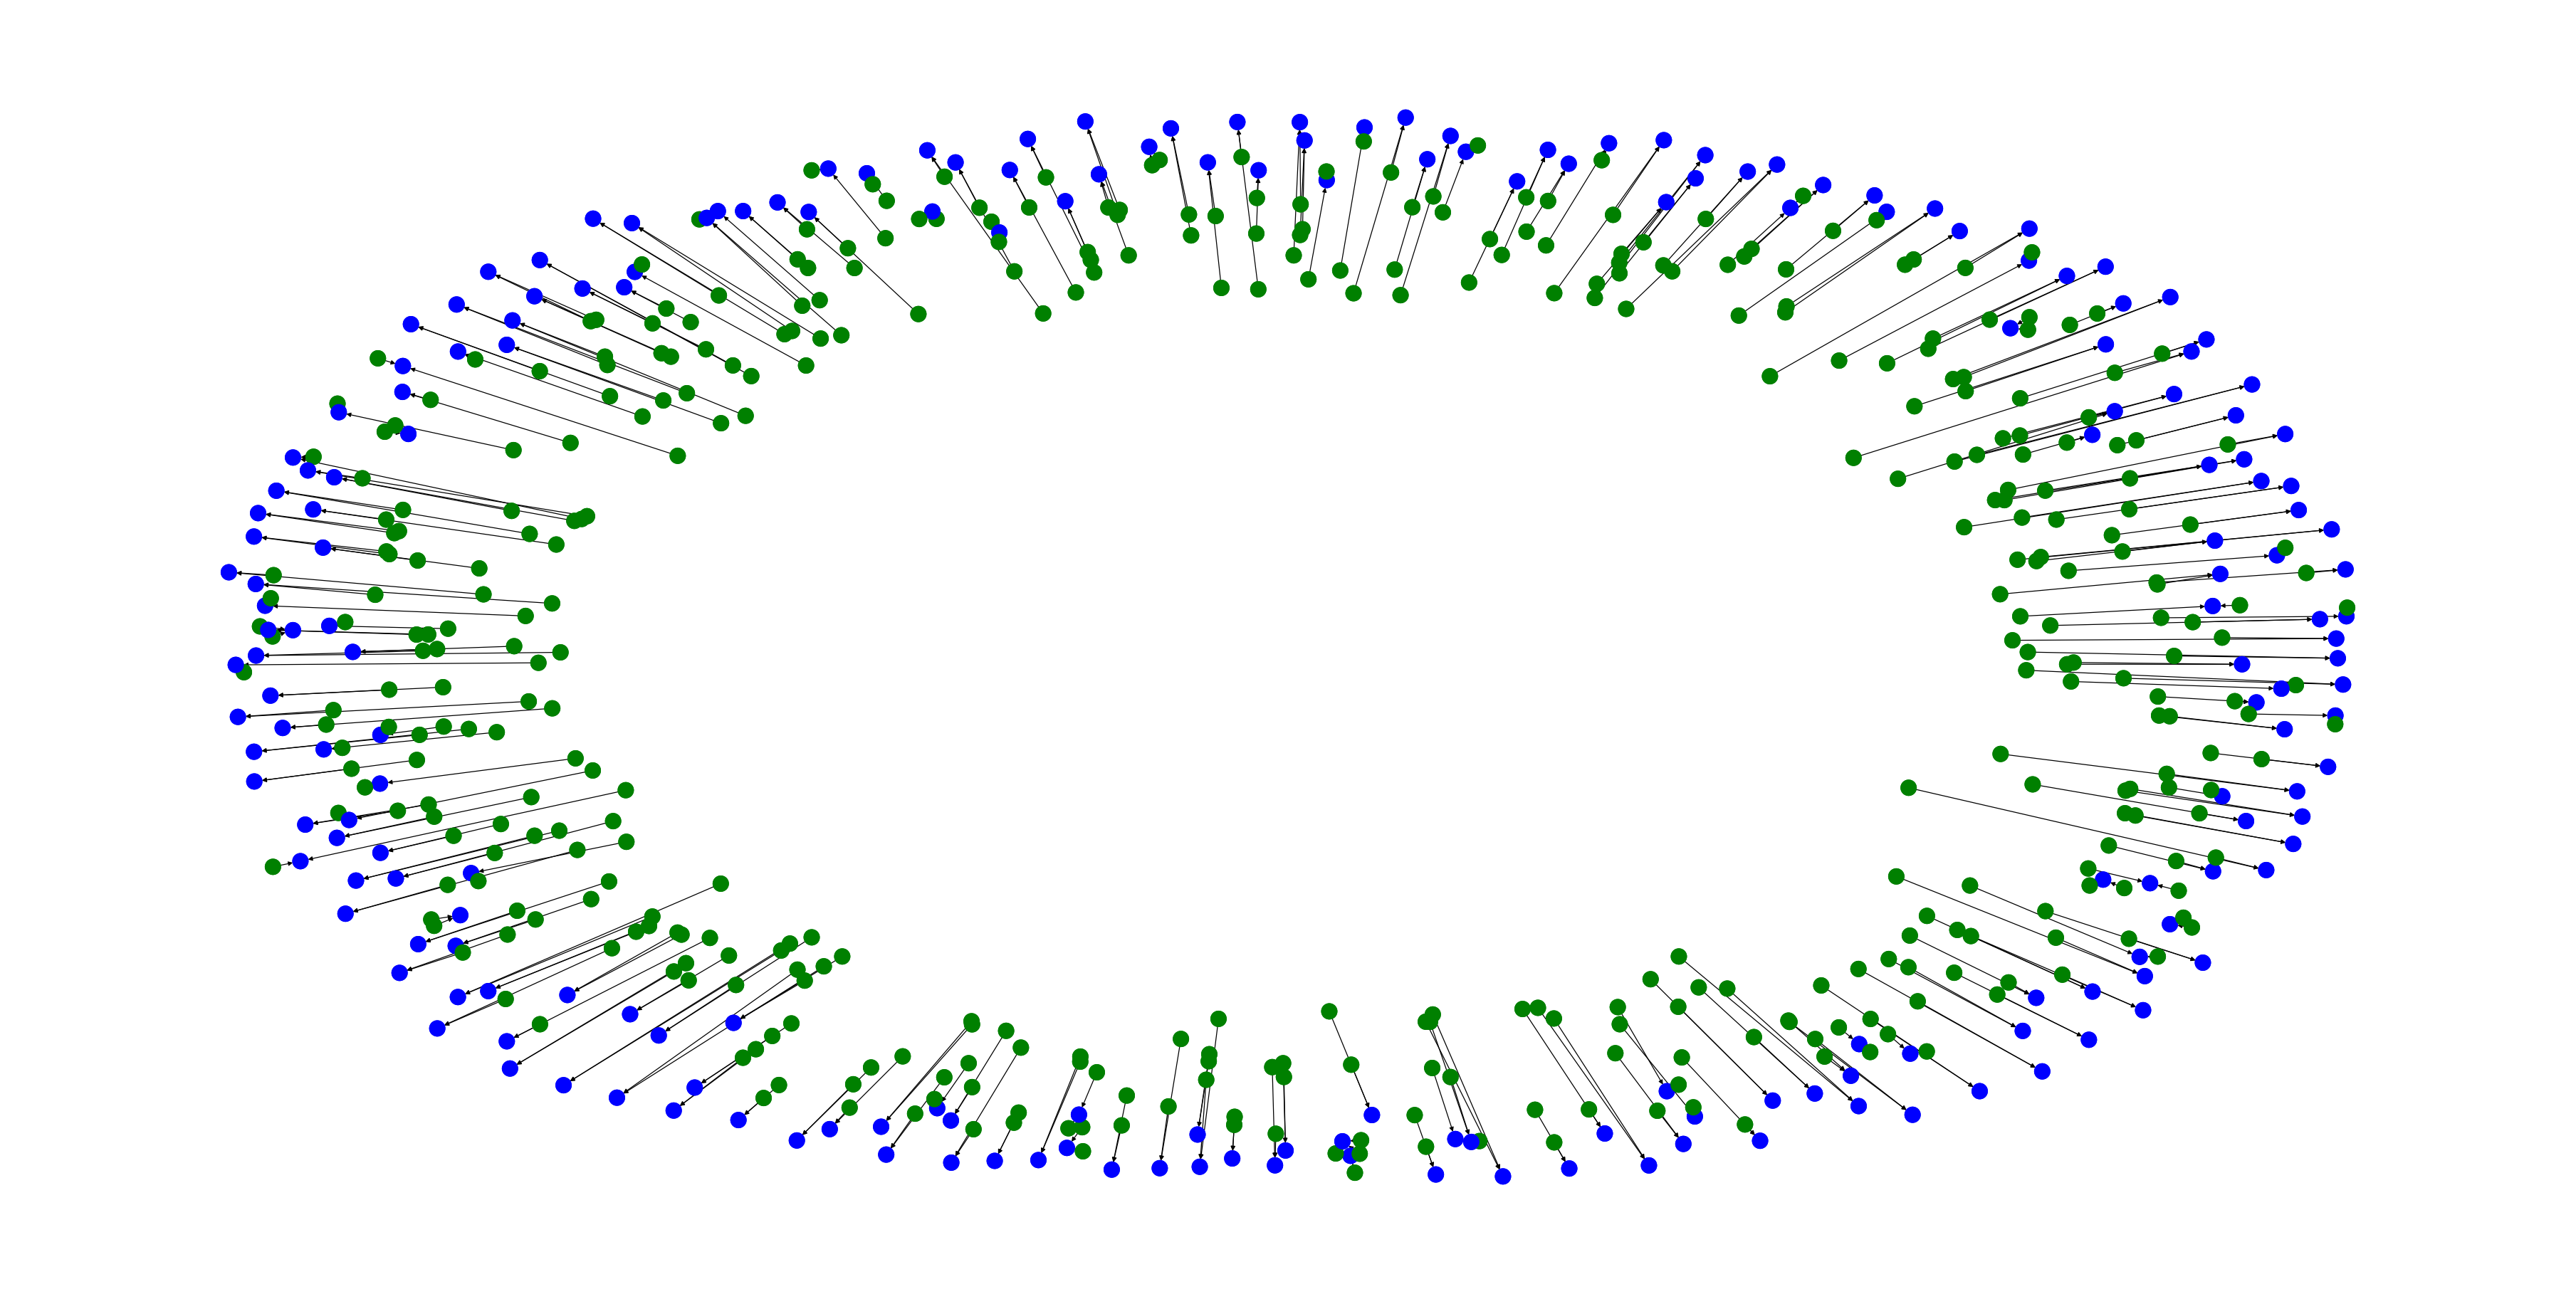

In [109]:
#plot group 2 transaction graph
G=init_graph(df_blk_graph_2,'token_vol',False,True)
plt_graph(G,df_blk_graph_2['to'].values)

In [129]:
# suspicious condition 
# batch 3:
# 22 transactions on evm with 2 'from' address.
eth_transactions=22
from_attrs=2

blk_addrs=set(df_blk_ords_graph[(df_blk_ords_graph['token_vol_count']==eth_transactions) & 
                                (df_blk_ords_graph['from_<lambda>']==from_attrs)]['addr'])
df_blk_addrs_3=pd.DataFrame(blk_addrs,columns=['to'])
df_blk_graph_3=pd.merge(df_graph_visual,df_blk_addrs_3,how='inner',on='to')

#suspicious behavior group3

batch3=df_all[(df_all['token_vol_count']==eth_transactions) & 
                                (df_all['from_<lambda>']==from_attrs)].sort_values(by='block_time')

batch3=batch3.rename(columns={"token_vol_sum": "total_volumn", "token_vol_count": "ETH","from_<lambda>":"froms"})
batch3['BSC']=0
batch3['Gnosis']=0
batch3['Optimism']=0
batch3['Arbitrum']=0

batch3.to_csv('sybil_attack_report_batch_3#307.csv')
batch3.head(3)

,addr,type,total_volumn,ETH,froms,block_time,BSC,Gnosis,Optimism,Arbitrum
95,0x29512e779221bec5745b3f8fb15a7d5347ce815d,ether,0.000003,22,2,"[2022-07-02T06:28:29Z, 2022-07-02T07:01:58Z, 2...",0,0,0,0
16,0x05a40740b2ef40dabee833322b0e3e0f299af989,ether,0.000003,22,2,"[2022-07-02T06:28:29Z, 2022-07-02T07:01:58Z, 2...",0,0,0,0
3,0x01f824d27bd96080f1c11e63d8268c8eeb147a5b,ether,0.000003,22,2,"[2022-07-02T06:28:29Z, 2022-07-02T07:01:58Z, 2...",0,0,0,0


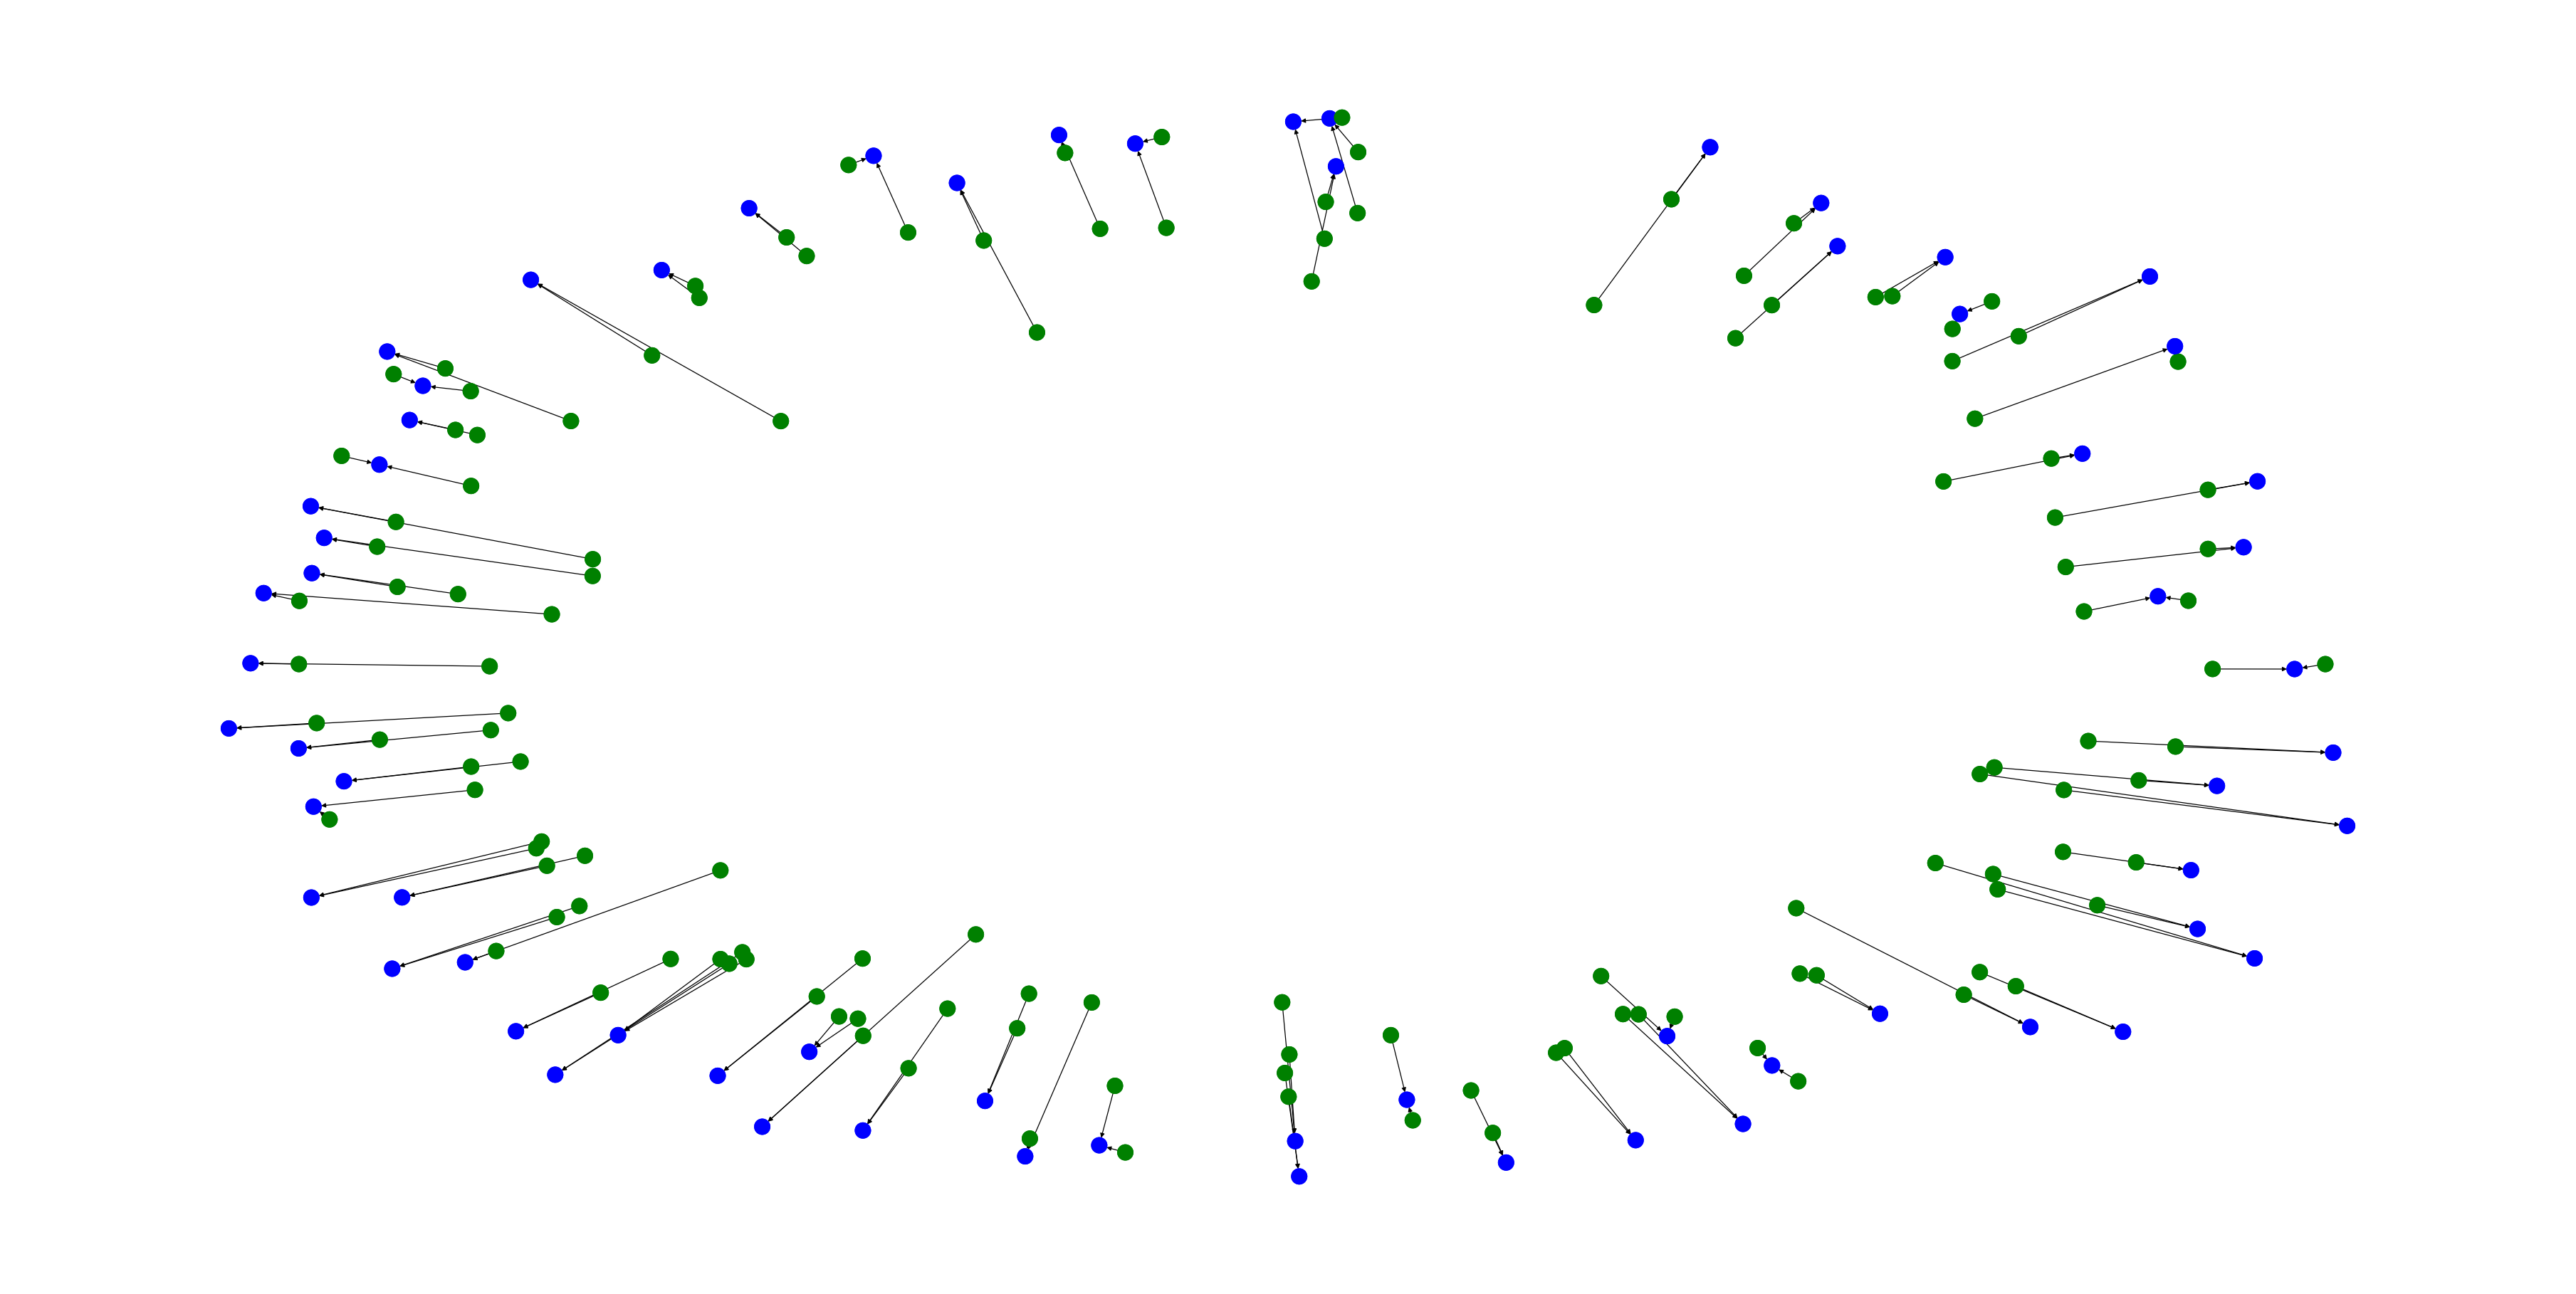

In [110]:
#plot group 2 transaction graph
G=init_graph(df_blk_graph_3,'token_vol',False,True)
plt_graph(G,df_blk_graph_3['to'].values)

In [130]:
# suspicious condition 
# batch 4:
# 23 transactions on evm with 2 'from' address.
eth_transactions=23
from_attrs=2

blk_addrs=set(df_blk_ords_graph[(df_blk_ords_graph['token_vol_count']==eth_transactions) & 
                                (df_blk_ords_graph['from_<lambda>']==from_attrs)]['addr'])

df_blk_addrs_4=pd.DataFrame(blk_addrs,columns=['to'])
df_blk_graph_4=pd.merge(df_graph_visual,df_blk_addrs_4,how='inner',on='to')

#suspicious behavior group1

batch4=df_all[(df_all['token_vol_count']==eth_transactions) & 
                                (df_all['from_<lambda>']==from_attrs)].sort_values(by='block_time')

batch4=batch4.rename(columns={"token_vol_sum": "total_volumn", "token_vol_count": "ETH","from_<lambda>":"froms"})
batch4['BSC']=0
batch4['Gnosis']=0
batch4['Optimism']=0
batch4['Arbitrum']=0
batch4.to_csv('sybil_attack_report_batch_4#307.csv')

batch4.head(3)

,addr,type,total_volumn,ETH,froms,block_time,BSC,Gnosis,Optimism,Arbitrum
584,0xe0516b54ac2b3290d900b6daf268064041b677ac,ether,0.000012,23,2,"[2022-06-21T06:52:55Z, 2022-06-21T06:53:35Z, 2...",0,0,0,0
467,0xb6217e0fbf91a8341570b0d6908987bbdad94404,ether,0.000003,23,2,"[2022-07-02T06:39:49Z, 2022-07-02T07:01:58Z, 2...",0,0,0,0
49,0x12e243d4ba55d4e4e02c81970d56b413adab2053,ether,0.000003,23,2,"[2022-07-02T06:39:49Z, 2022-07-02T07:01:58Z, 2...",0,0,0,0


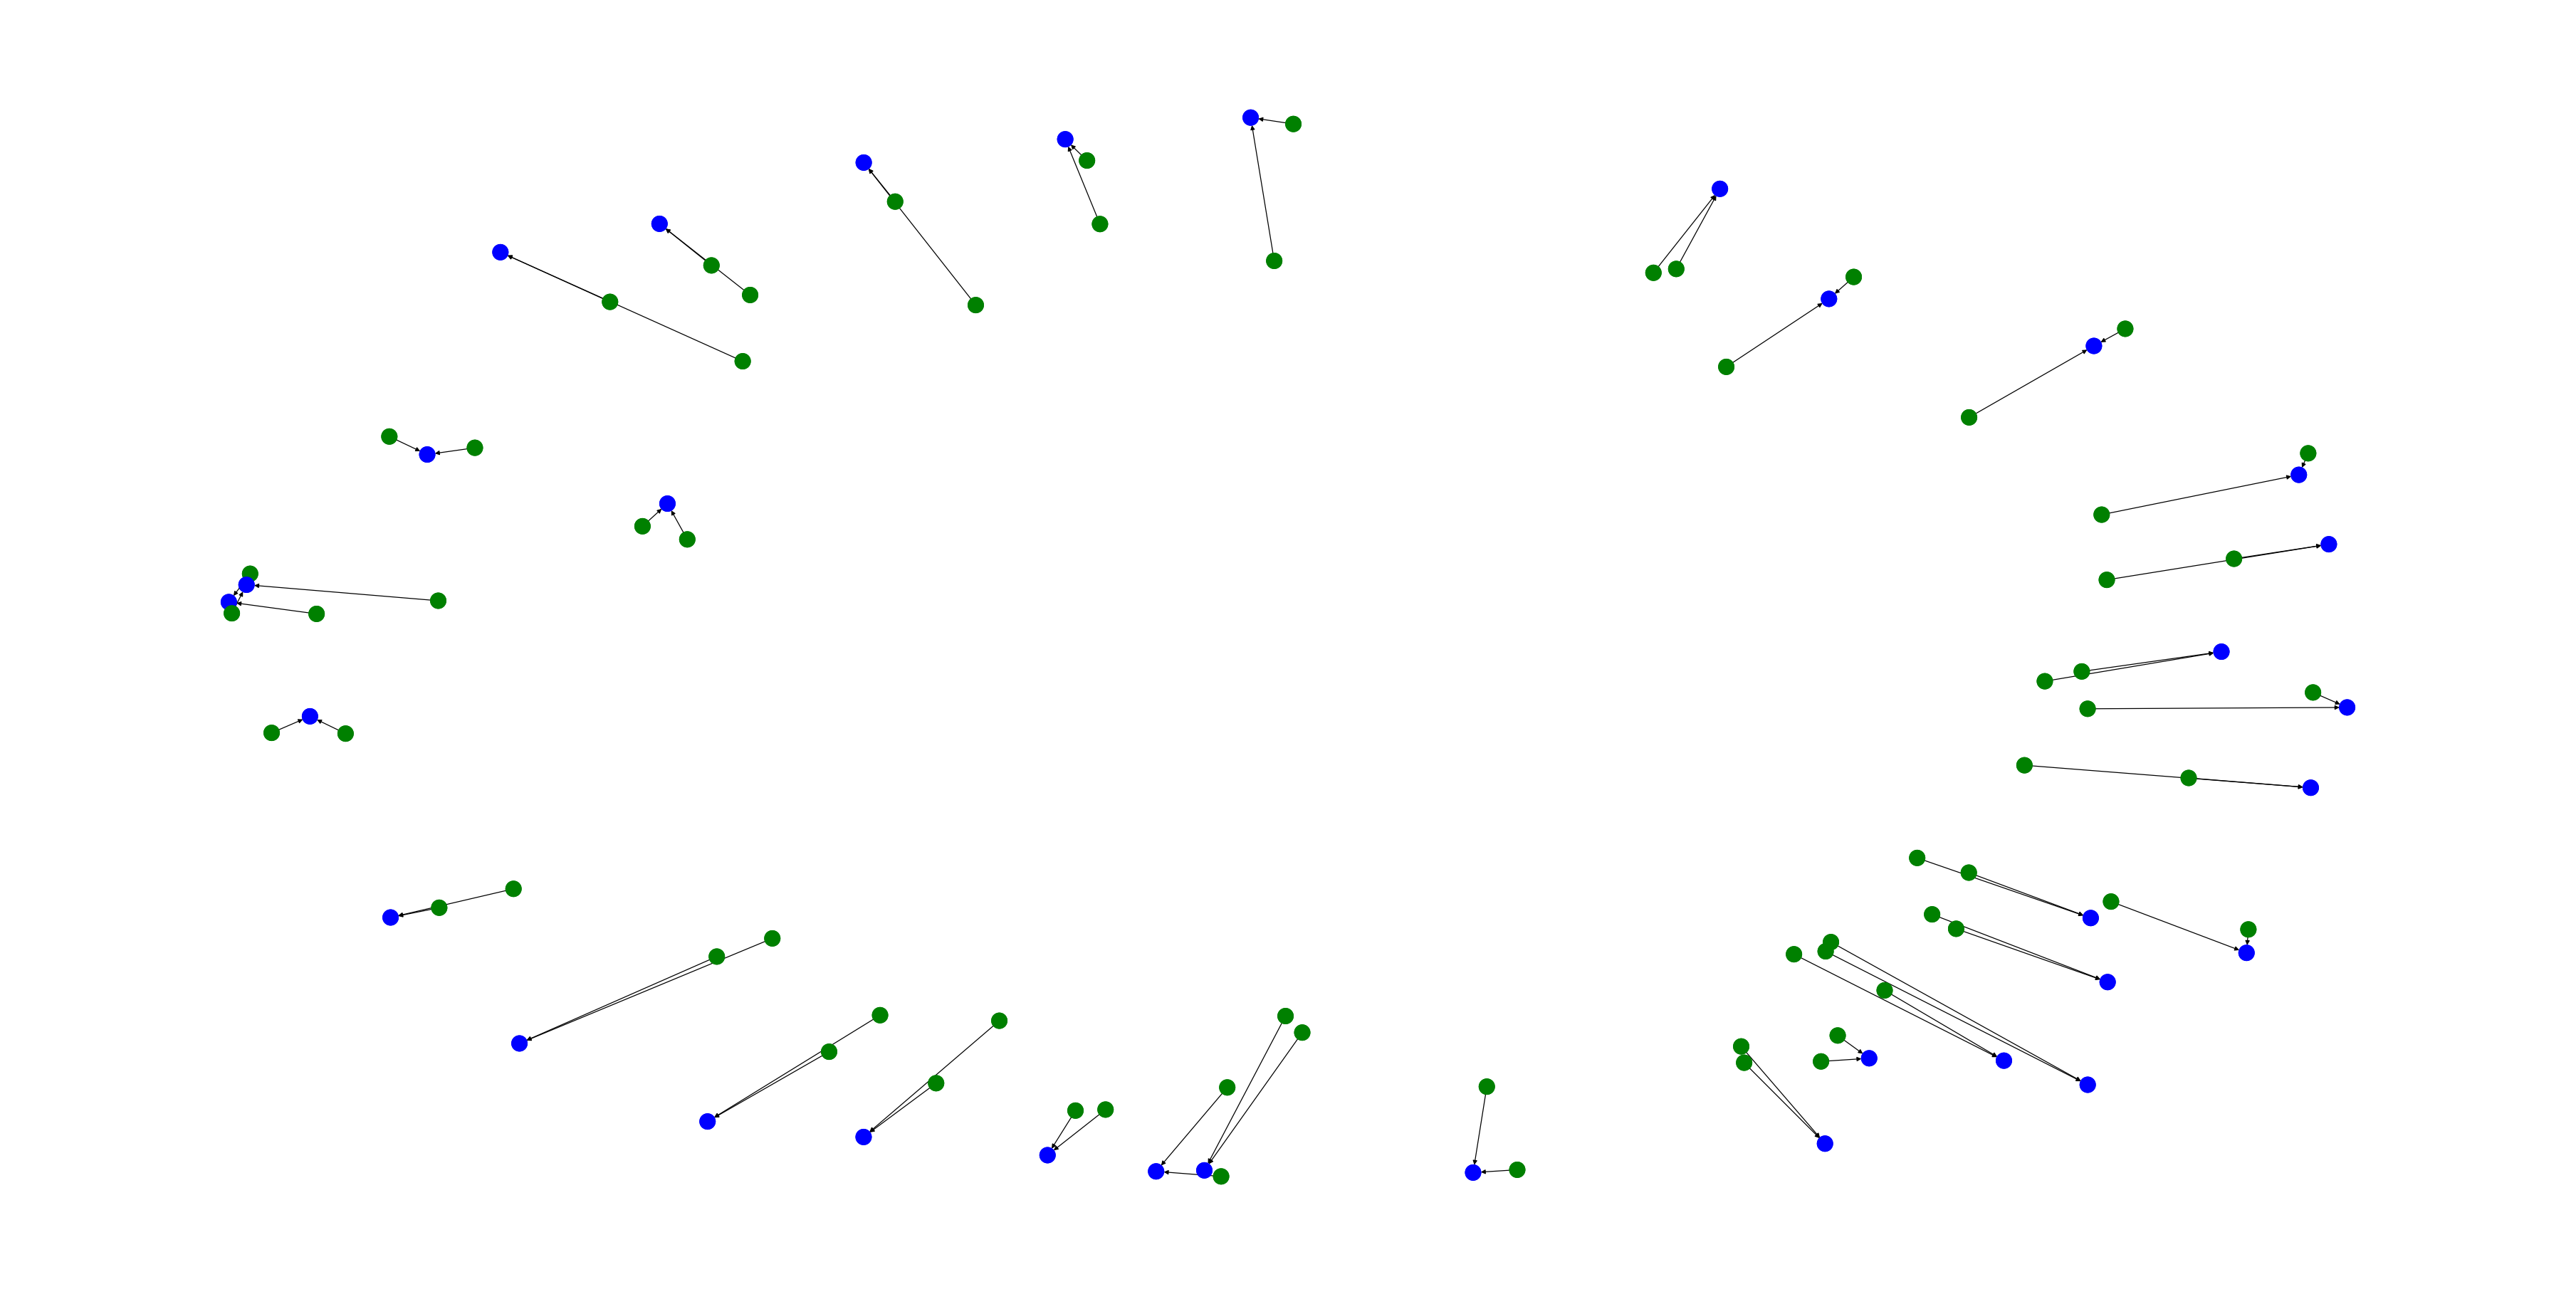

In [122]:
#plot group 4 transaction graph
G=init_graph(df_blk_graph_4,'token_vol',False,True)
plt_graph(G,df_blk_graph_4['to'].values)

In [131]:
# suspicious condition 
# batch 5:
# 21 transactions on evm with 2 'from' address.
eth_transactions=21
from_attrs=2

blk_addrs=set(df_blk_ords_graph[(df_blk_ords_graph['token_vol_count']==eth_transactions) & 
                                (df_blk_ords_graph['from_<lambda>']==from_attrs)]['addr'])
df_blk_addrs_5=pd.DataFrame(blk_addrs,columns=['to'])
df_blk_graph_5=pd.merge(df_graph_visual,df_blk_addrs_5,how='inner',on='to')

#suspicious behavior group1

batch5=df_all[(df_all['token_vol_count']==eth_transactions) & 
                                (df_all['from_<lambda>']==from_attrs)].sort_values(by='block_time')

batch5=batch5.rename(columns={"token_vol_sum": "total_volumn", "token_vol_count": "ETH","from_<lambda>":"froms"})
batch5['BSC']=0
batch5['Gnosis']=0
batch5['Optimism']=0
batch5['Arbitrum']=0
batch5.to_csv('sybil_attack_report_batch_5#307.csv')

batch5.head(3)

,addr,type,total_volumn,ETH,froms,block_time,BSC,Gnosis,Optimism,Arbitrum
199,0x55497147f00a78aa4d896a2ae1e219000fad77dc,ether,0.000003,21,2,"[2022-07-02T06:28:29Z, 2022-07-02T07:01:58Z, 2...",0,0,0,0
246,0x66e940edc253218632225d72bbfc512d0d61d737,ether,0.000003,21,2,"[2022-07-02T06:28:29Z, 2022-07-02T07:01:58Z, 2...",0,0,0,0
105,0x2d82397525f495465d215c167b4fe0447504be01,ether,0.000003,21,2,"[2022-07-02T06:39:37Z, 2022-07-02T07:01:58Z, 2...",0,0,0,0


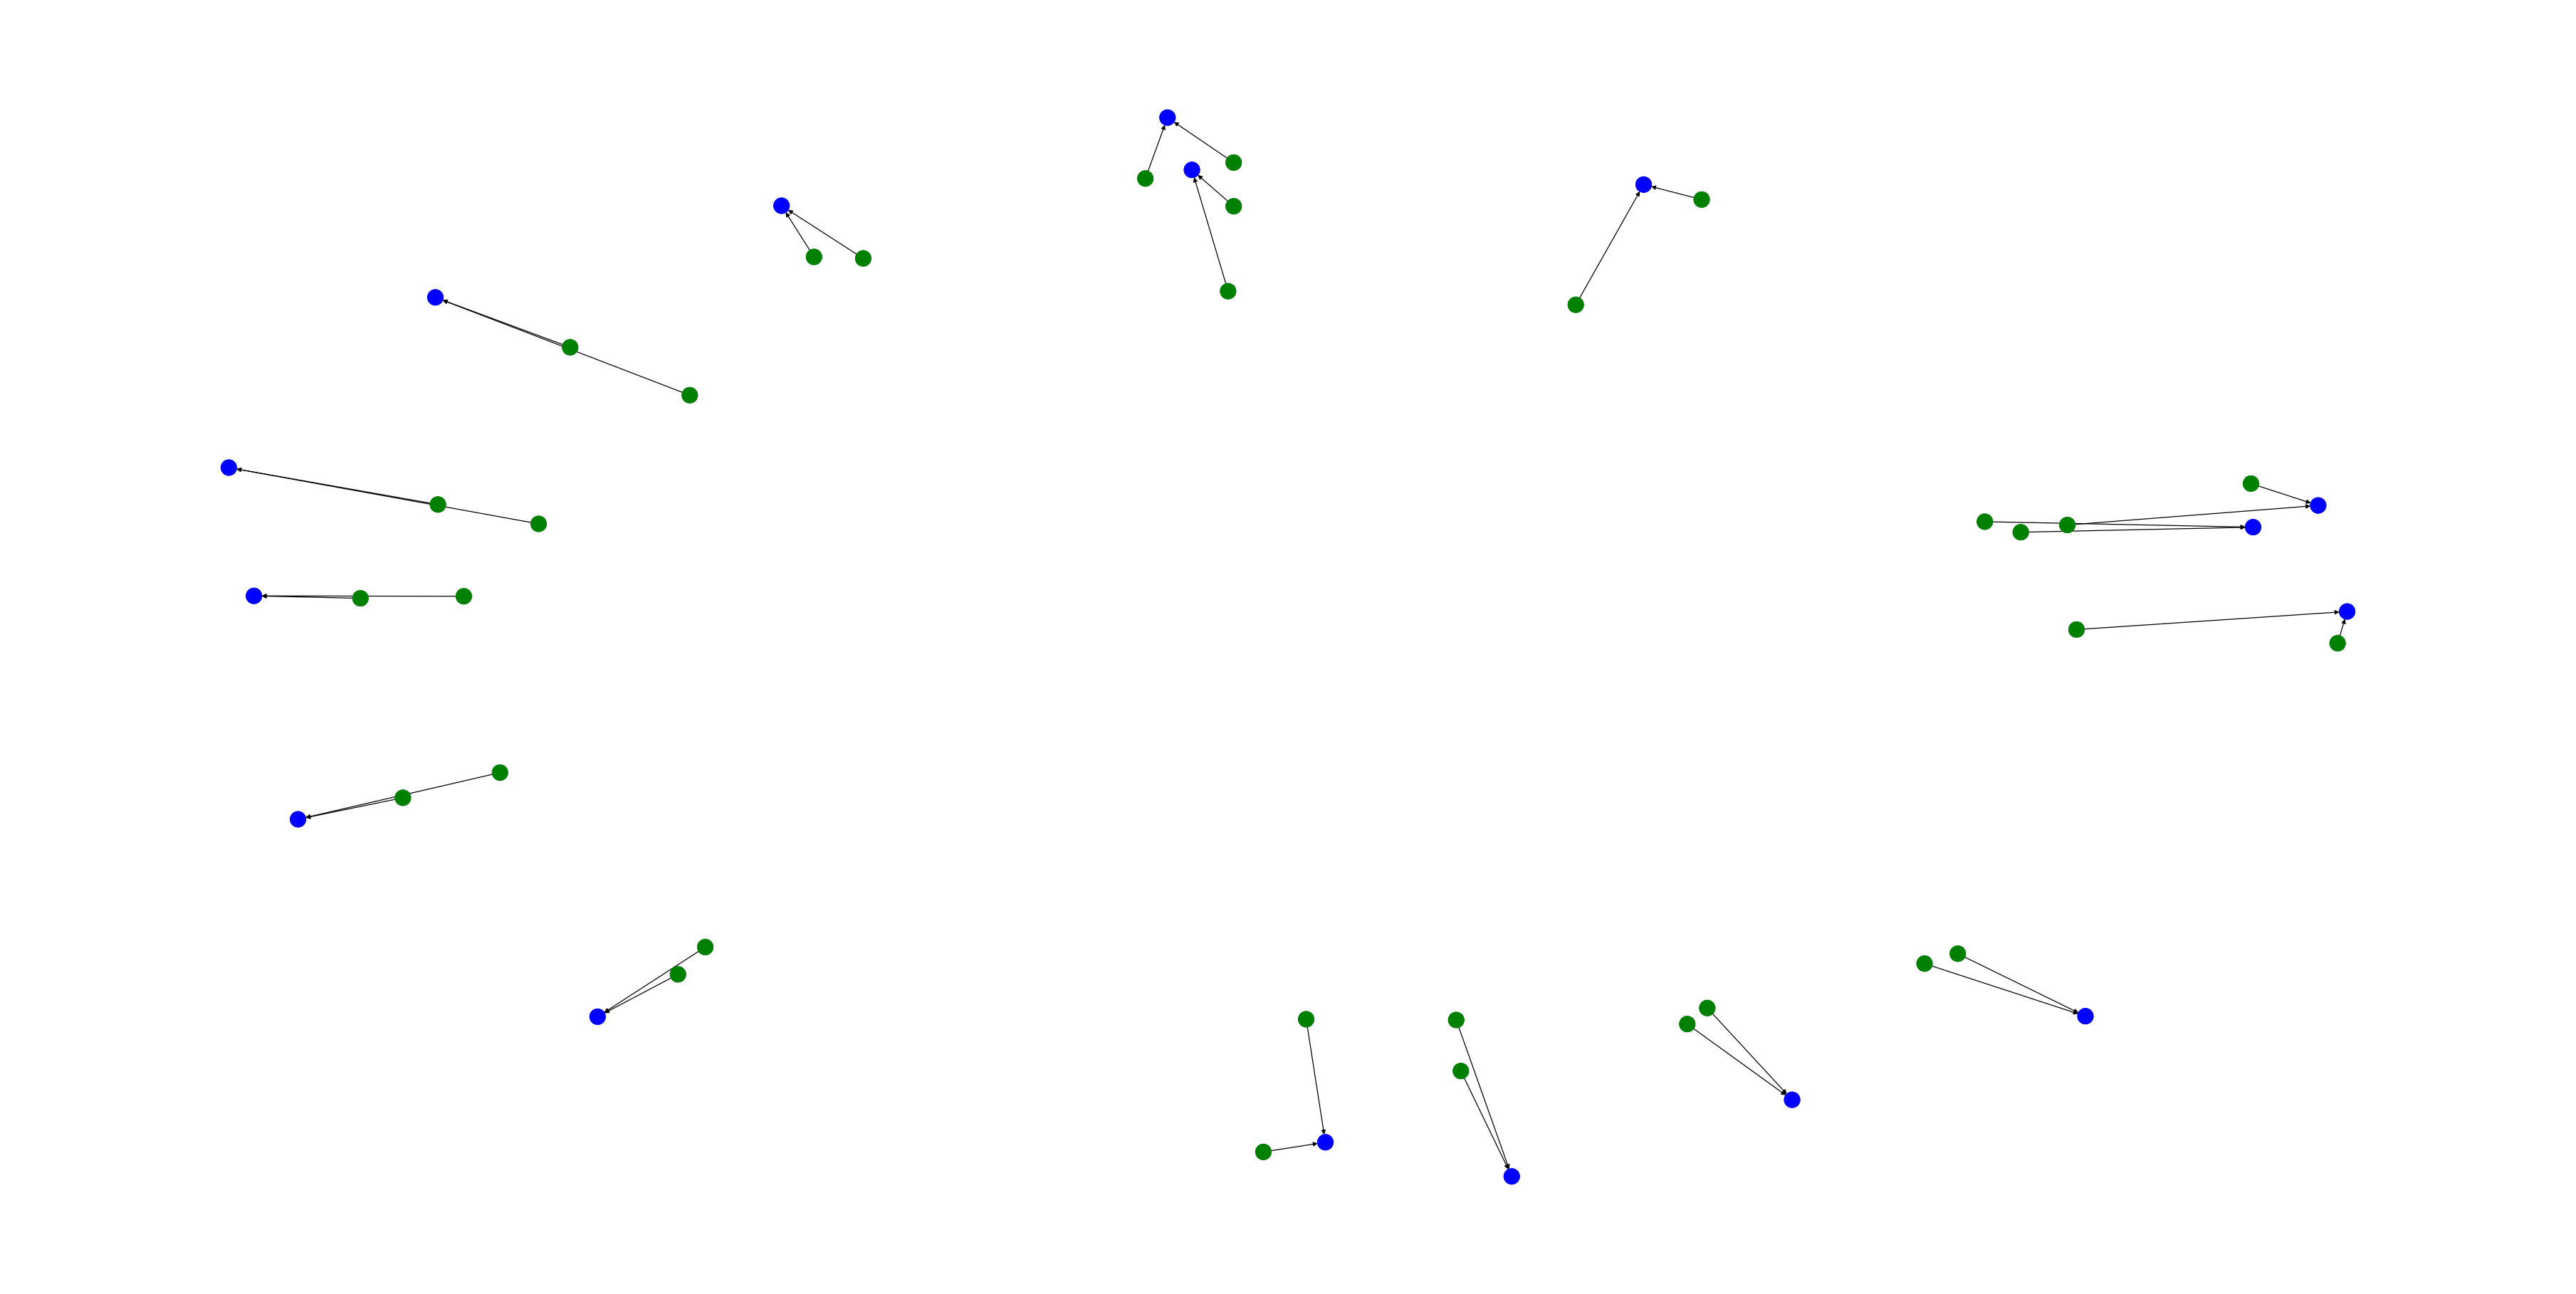

In [124]:
#plot group 5 transaction graph
G=init_graph(df_blk_graph_5,'token_vol',False,True)
plt_graph(G,df_blk_graph_5['to'].values)